# 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import warnings ; warnings.filterwarnings('ignore')

from autogluon.tabular import TabularDataset, TabularPredictor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler

# 데이터 불러오기

In [2]:
train = pd.read_csv("/Users/mingu/Desktop/CODING/2024_1 Machine Learning/Kaggle Project 2/DATASET/train.csv").drop("~", axis = 1) #경로지정
test = pd.read_csv("/Users/mingu/Desktop/CODING/2024_1 Machine Learning/Kaggle Project 2/DATASET/test.csv").drop("No", axis = 1)
sample_sub = pd.read_csv("/Users/mingu/Desktop/CODING/2024_1 Machine Learning/Kaggle Project 2/DATASET/submission.csv")

# seed 고정

In [3]:
# Reproducibility setup
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 파라미터 설정

In [4]:
TARGET = "Death"

# 전처리

## EDA

In [5]:
train[TARGET].value_counts()

Death
0    7897
1    2103
Name: count, dtype: int64

## feature engineering


In [6]:
def preprocessing(data):
    # Lung cancer TNM stage
    #T
    data.loc[(data['M1a'] == 1 ) | (data['M1b'] == 1) | (data['M1c'] == 1), 'M0' ] = 0 
    data.loc[(data['M1a'] == 0) & (data['M1b'] == 0) & (data['M1c'] == 0),'M0'] = 1

    #N
    data.loc[(data['N1'] == 1 ) | (data['N2'] == 1) | (data['N3'] == 1), 'N0'] = 0
    data.loc[(data['N1'] == 0) & (data['N2'] == 0) & (data['N3'] == 0), 'N0'] = 1
    #M
    
    #stage
    data['TNM_stage'] = ''

    stage_map = {

        ('T1', 'N0'): 'IA', ('T1', 'N1'): 'IIA', ('T1', 'N2'): 'IIB', ('T1', 'N3'): 'IIIA', 
        ('T1a', 'N0'): 'IA', ('T1a', 'N1'): 'IIA', ('T1a', 'N2'): 'IIB', ('T1a', 'N3'): 'IIIA',
        ('T1b', 'N0'): 'IA', ('T1b', 'N1'): 'IIA', ('T1b', 'N2'): 'IIB', ('T1b', 'N3'): 'IIIA', 
        ('T1c', 'N0'): 'IA', ('T1c', 'N1'): 'IIA', ('T1c', 'N2'): 'IIB', ('T1c', 'N3'): 'IIIA', 
        ('T2', 'N0'): 'IB', ('T2', 'N1'): 'IIB', ('T2', 'N2'): 'IIIA', ('T2', 'N3'): 'IIIB',
        ('T2a', 'N0'): 'IB', ('T2a', 'N1'): 'IIB', ('T2a', 'N2'): 'IIIA', ('T2a', 'N3'): 'IIIB', 
        ('T2b', 'N0'): 'IIA', ('T2b', 'N1'): 'IIB', ('T2b', 'N2'): 'IIIA', ('T2b', 'N3'): 'IIIB', 
        ('T3', 'N0'): 'IIB', ('T3', 'N1'): 'IIIA', ('T3', 'N2'): 'IIIA', ('T3', 'N3'): 'IIIB',
        ('T4', 'N0'): 'IIIA', ('T4', 'N1'): 'IIIA', ('T4', 'N2'): 'IIIB', ('T4', 'N3'): 'IIIC'
    }

    for t in ['T1', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4']:
        for n in ['N0', 'N1', 'N2', 'N3']:
            mask = (data[t] == 1) & (data[n] == 1)
            target = stage_map.get((t, n), 'Invalid TNM')
            data.loc[mask, 'TNM_stage'] = target
            if target == 'Invalid TNM':
                print((t, n))

    data.loc[data['M1a'] == 1, 'TNM_stage'] = 'IVA'
    data.loc[data['M1b'] == 1, 'TNM_stage'] = 'IVA'
    data.loc[data['M1c'] == 1, 'TNM_stage'] = 'IVB'

    stage_encode = {'' : 0, 'IA' : 1, "IB" : 2, "IIA" : 3, "IIB" : 4 , "IIIA" : 5, "IIIB" : 6, "IIIC": 7, "IVA": 8, "IVB":9}
    stage_encode2 = {0 : 0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4}
    data['TNM_stage'] = data['TNM_stage'].map(stage_encode)
    data['TNM_bigstage'] = data['TNM_stage'].map(stage_encode2)
    
    # Surgery
    data['Therapy_count'] = data['Operation'] + data['Chemotherapy'] + data['Radiation Therapy']

    # Other
    data['BMI'] = data['Weight'] / (data['Height'] / 100) ** 2

    # EGFR mutation Detection encoding 99 -> 0
    data['EGFR mutation Detection'] = data['EGFR mutation Detection'].replace(99, 2)

    # Type of Drink encoding 99 -> 0
    data['Type of Drink'] = data['Type of Drink'].replace(99, 0)

    # Mu
    return data

In [7]:
train = preprocessing(train)
test = preprocessing(test)

# train

In [8]:
train_data = TabularDataset(train)
test_data = TabularDataset(test)

In [9]:
save_path = '/Users/mingu/Desktop/CODING/2024_1 Machine Learning/Kaggle Project 2/MODEL_SAVE/ag_EDA' #save 경로


In [10]:
predictor = TabularPredictor(
    label = TARGET,
    path = save_path,
    eval_metric = 'accuracy',
).fit(
    train_data=train_data,
    presets='best_quality',
    time_limit=3600*100,
    num_stack_levels=3,
)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 360000 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: /Users/mingu/Desktop/CODING/2024_1 Machine Learning/Kaggle Project 2/MODEL_SAVE/ag_EDA/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 90000s
AutoGluon will save models to "/Users/mingu/Desktop/CODING/2024_1 Machine Learning/Kaggle Project 2/MODEL_SAVE/ag_EDA/ds_sub_fit/sub_fit_ho"
=================== System Info ===============

KeyboardInterrupt: 

# submission

In [ ]:
save_path = '/Users/mingu/Desktop/CODING/2024_1 Machine Learning/Kaggle Project 2/MODEL_SAVE/ag2'

In [ ]:
predictor = TabularPredictor.load(path = save_path)

In [ ]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_r135_BAG_L4,0.515288,balanced_accuracy,14.266755,5173.694104,0.136760,116.372698,4,True,248
1,CatBoost_r50_BAG_L4,0.515095,balanced_accuracy,14.159249,5078.279310,0.029254,20.957904,4,True,219
2,XGBoost_r89_BAG_L4,0.514932,balanced_accuracy,14.156861,5065.763550,0.026866,8.442143,4,True,217
3,LightGBM_r130_BAG_L4,0.514628,balanced_accuracy,14.210895,5133.494855,0.080900,76.173449,4,True,218
4,XGBoost_r49_BAG_L4,0.514348,balanced_accuracy,14.153883,5067.001073,0.023888,9.679667,4,True,240
...,...,...,...,...,...,...,...,...,...,...
243,ExtraTreesEntr_BAG_L1,0.499644,balanced_accuracy,0.192875,0.348717,0.192875,0.348717,1,True,9
244,RandomForest_r166_BAG_L2,0.499573,balanced_accuracy,4.199097,1105.098065,0.200340,1.294449,2,True,114
245,ExtraTrees_r42_BAG_L1,0.499413,balanced_accuracy,0.175892,0.488546,0.175892,0.488546,1,True,17
246,KNeighborsUnif_BAG_L1,0.493381,balanced_accuracy,0.051505,0.004499,0.051505,0.004499,1,True,1


In [ ]:
pred = predictor.predict_proba(test_data)

In [ ]:
pred


,0,1
0,0.771756,0.228244
1,0.791950,0.208050
2,0.769427,0.230573
3,0.754601,0.245399
4,0.763062,0.236938
...,...,...
4995,0.761634,0.238366
4996,0.734053,0.265947
4997,0.783093,0.216907
4998,0.770656,0.229344


(array([  5.,  11.,  52.,  94., 168., 263., 355., 441., 479., 477., 476.,
        425., 384., 315., 268., 203., 166., 105.,  91.,  68.,  51.,  32.,
         25.,  12.,  10.,   6.,   5.,   4.,   4.,   2.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.17778723, 0.1843638 , 0.19094037, 0.19751694, 0.20409351,
        0.21067008, 0.21724665, 0.22382322, 0.23039979, 0.23697636,
        0.24355294, 0.25012951, 0.25670608, 0.26328265, 0.26985922,
        0.27643579, 0.28301236, 0.28958893, 0.2961655 , 0.30274207,
        0.30931864, 0.31589521, 0.32247178, 0.32904835, 0.33562492,
        0.34220149, 0.34877806, 0.35535463, 0.36193121, 0.36850778,
        0.37508435, 0.38166092, 0.38823749, 0.39481406, 0.40139063,
        0.4079672 , 0.41454377, 0.42112034, 0.42769691, 0.43427348,
        0.44085005, 0.44742662, 0.45400319, 0.46057976, 0.46715633,
        0.47373291, 0.48030948, 0.48688605, 0.

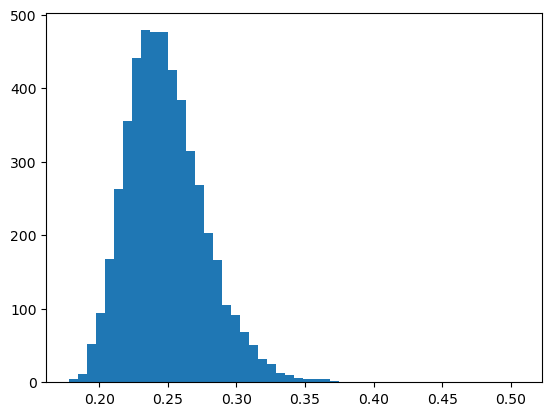

In [ ]:
# pred의 predict_proba를 시각화
plt.hist(pred[1], bins=50)

In [ ]:
for tresh_hold in np.arange(0.1, 1, 0.01):
    print(f"Threshold: {tresh_hold}")
    print(sum(np.where(pred[1] > tresh_hold, 1, 0)))

Threshold: 0.1
5000
Threshold: 0.11
5000
Threshold: 0.12
5000
Threshold: 0.13
5000
Threshold: 0.13999999999999999
5000
Threshold: 0.14999999999999997
5000
Threshold: 0.15999999999999998
5000
Threshold: 0.16999999999999998
5000
Threshold: 0.17999999999999997
4999
Threshold: 0.18999999999999995
4987
Threshold: 0.19999999999999996
4910
Threshold: 0.20999999999999996
4688
Threshold: 0.21999999999999995
4266
Threshold: 0.22999999999999993
3635
Threshold: 0.23999999999999994
2912
Threshold: 0.24999999999999994
2187
Threshold: 0.2599999999999999
1552
Threshold: 0.2699999999999999
1050
Threshold: 0.2799999999999999
671
Threshold: 0.2899999999999999
413
Threshold: 0.29999999999999993
262
Threshold: 0.3099999999999999
145
Threshold: 0.3199999999999999
85
Threshold: 0.3299999999999999
45
Threshold: 0.33999999999999986
25
Threshold: 0.34999999999999987
17
Threshold: 0.3599999999999999
12
Threshold: 0.3699999999999999
4
Threshold: 0.3799999999999999
2
Threshold: 0.38999999999999985
2
Threshold: 0.3

In [ ]:
pred = np.where(pred[1] > 0.31, 1, 0)

In [ ]:
sample_sub["Death"] = pred

In [ ]:
sample_sub['Death'].value_counts()

Death
0    4855
1     145
Name: count, dtype: int64

In [ ]:
sample_sub.to_csv("/Users/mingu/Desktop/CODING/2024_1 Machine Learning/Kaggle Project 2/SUBMISSION/5_8_threshhold_031.csv", index=False) #path